<a href="https://colab.research.google.com/github/davidrata/week10/blob/main/Unsupervised_Classification_of_First_Year_and_Multi_Year_Sea_Ice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning for Sea Ice Classification

In this project, we explore how **unsupervised machine learning** can help us classify **sea ice types** — specifically distinguishing between **First-Year Ice (FYI)** and **Multi-Year Ice (MYI)** — using radar waveform features captured by **Sentinel-3 altimetry (SRAL)**.

Unsupervised learning is a branch of machine learning where we work with **unlabeled data**. That means we don’t explicitly tell the algorithm what each data point represents (e.g. “this is FYI, this is MYI”). Instead, we let the algorithm **discover patterns** or **groupings** in the data on its own.

These methods are especially useful in **remote sensing** scenarios, where labeled datasets are limited or unavailable — such as in polar environments, where distinguishing ice types manually is costly and time-consuming.

---

##  What Makes FYI and MYI Different?

Although both are sea ice, FYI and MYI differ in several physical and surface properties:
- **FYI**: younger, smoother, thinner, simpler radar response
- **MYI**: older, rougher, thicker, more complex waveform structure

We can extract these differences from waveform-derived features like:
- **Peakiness** (sharpness of the radar return)
- **Backscatter (σ₀)** — signal strength returned to the satellite
- **SSD (Stack Standard Deviation)** — captures waveform spread

---

## 📌 Tasks Covered in This Notebook
🔹 Apply clustering techniques (e.g. K-means, GMM)  
🔹 Extract waveform features from Sentinel-3 altimetry (`enhanced_measurement.nc`)  
🔹 Visualize waveform groupings and interpret likely ice types  

By the end of this notebook, you'll understand how to perform real-world classification of sea ice types using **unsupervised learning + satellite radar altimetry**


In [1]:
#mount your google drive where the files are located
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install required packages
!pip install -q rasterio netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.7 MB/s eta 0:00:00


## ⚙️ K-Means Clustering — Demonstration

To build intuition for how unsupervised clustering works, we begin with a simple **K-Means example** using randomly generated 2D data points. This synthetic setup visually shows how the algorithm separates data into distinct groups based on feature similarity.

In the example below, we simulate 100 random points in a 2D space and use K-Means to split them into **two clusters** — analogous to how we later aim to classify **First-Year Ice (FYI)** vs. **Multi-Year Ice (MYI)** using radar waveform features.

K-Means works by assigning each point to the nearest cluster centroid and updating those centroids iteratively. Although it assumes that clusters are well-separated and spherical, this demonstration helps illustrate the basic mechanics behind the algorithm — and how it partitions the data by minimizing variance within each group.

This toy example lays the foundation for applying K-Means to real altimetry-derived features like **peakiness**, **backscatter**, and **SSD**, where clustering can reveal physically meaningful ice types without relying on labeled data.


In [3]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt

# Clustering and scaling
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Geospatial and data I/O
import rasterio
from netCDF4 import Dataset


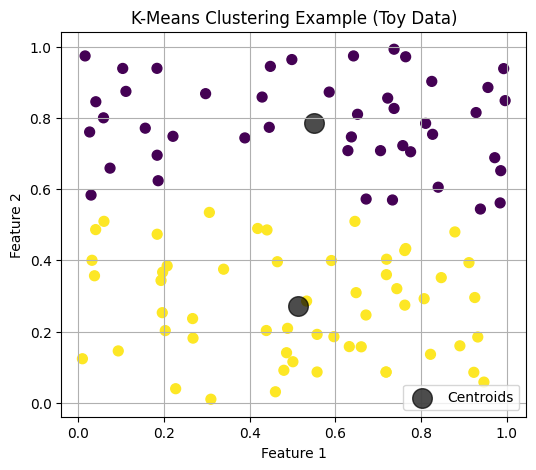

In [4]:

# Demonstrating K-Means Clustering with Toy Data

# This example shows how unsupervised clustering works on random 2D points.
# It helps us understand the idea of separating data into groups based on similarity.

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Generate 100 random 2D points
X = np.random.rand(100, 2)

# Fit K-Means with 2 clusters (like FYI vs MYI)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plot results
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='black', s=200, alpha=0.7, label='Centroids')
plt.title('K-Means Clustering Example (Toy Data)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

# gmm.fit(feature_matrix)  # with your real data
# y_pred = gmm.predict(feature_matrix)


## 🧠 Gaussian Mixture Model (GMM) — Demonstration

While K-Means assumes hard boundaries between clusters, GMM provides a **probabilistic framework** where each data point has a probability of belonging to each cluster. This makes it more flexible — and often more realistic — when working with natural systems like sea ice.

In the example below, we generate synthetic 2D data and cluster it using GMM to illustrate how the algorithm forms **soft clusters** with overlapping regions. This helps us later interpret clustering results on waveform-based sea ice features (e.g. peakiness, backscatter, SSD).


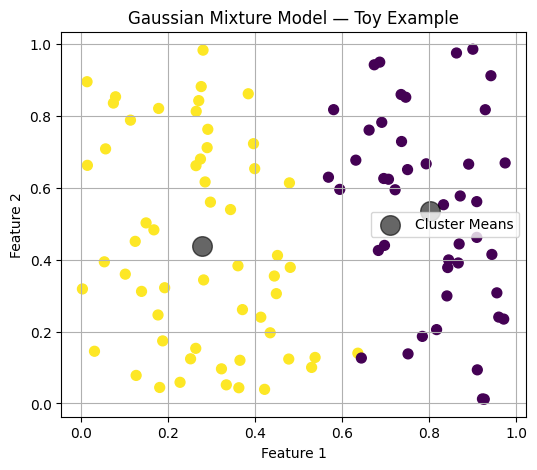

In [5]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Generate some synthetic 2D data points
X = np.random.rand(100, 2)

# Fit Gaussian Mixture Model with 2 components (analogous to FYI vs MYI)
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X)

# Predict cluster labels (most likely cluster for each point)
y_gmm = gmm.predict(X)

# Plot the data points colored by cluster
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y_gmm, cmap='viridis', s=50)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1],
            c='black', s=200, alpha=0.6, label='Cluster Means')
plt.title('Gaussian Mixture Model — Toy Example')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.legend()
plt.show()


# K-Means and GMM Implementation

## 🛰️ Visual Segmentation of Arctic Sea Ice (Sentinel-2 Support Layer)

Although our primary classification of First-Year Ice (FYI) vs Multi-Year Ice (MYI) is based on Sentinel-3 SRAL radar waveform features, we can also apply unsupervised learning to Sentinel-2 optical imagery as a **contextual support layer**.

Sea ice and leads have different optical reflectance — leads typically appear darker in visible wavelengths, while compact FYI or MYI appears brighter. In this section, we apply **K-Means clustering** on Band 4 (Red) reflectance to segment the surface into two classes. This isn't our final classification but helps visualize surface variation and identify potential open water or thin ice zones.

This will later help us validate or compare against the SRAL-derived radar clusters.


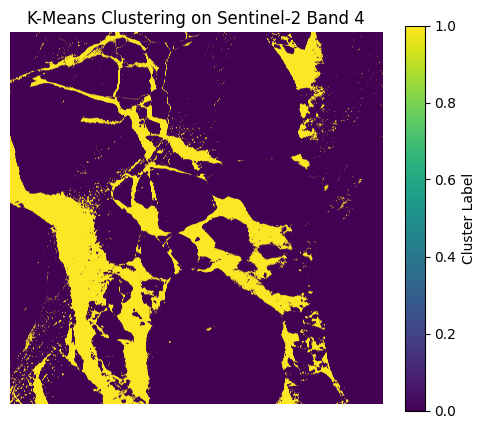

In [1]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Specify path to Sentinel-2 bands
base_path = "/content/drive/MyDrive/fypp/S2B_MSIL1C_20240501T203839_N0510_R014_T09XWA_20240501T235028.SAFE/GRANULE/L1C_T09XWA_A037363_20240501T203838/IMG_DATA/"
bands_paths = {
    'B4': base_path + 'T09XWA_20240501T203839_B04.jp2',
    'B3': base_path + 'T09XWA_20240501T203839_B03.jp2',
    'B2': base_path + 'T09XWA_20240501T203839_B02.jp2'
}


# Read one band (e.g. Band 4 - Red) for simple clustering
band_data = []
for band in ['B4']:  # You can change to ['B3', 'B2'] for full RGB clustering
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack into a 3D array
band_stack = np.dstack(band_data)

# Create mask for valid pixels (non-zero)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Prepare data for clustering (flatten valid pixels)
X = band_stack[valid_data_mask].reshape((-1, 1))  # 1D if using single band

# Apply K-Means clustering (2 clusters = assumed FYI vs MYI based on reflectance difference)
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_

# Create labeled image with default -1 (no data)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)
labels_image[valid_data_mask] = labels

# Plot clustering result
plt.figure(figsize=(6, 5))
plt.imshow(labels_image, cmap='viridis')
plt.title('K-Means Clustering on Sentinel-2 Band 4')
plt.colorbar(label='Cluster Label')
plt.axis('off')
plt.show()

# Clean up memory
del kmeans, labels, band_data, band_stack, valid_data_mask, X, labels_image

# Apply K-Means clustering (2 clusters = FYI vs MYI hypothesis based on reflectance)
# Brighter regions = likely First-Year Ice (FYI)
# Darker regions = likely Multi-Year Ice (MYI)



### 🧊 Observations from K-Means Clustering on Sentinel-2 Band 4

The figure above illustrates the result of applying **K-Means clustering** (with `n_clusters=2`) to **Sentinel-2 Band 4 (Red)** reflectance values over Arctic sea ice.

### Key Observations:

- The clustering clearly separates the image into two distinct surface types:
  - **Cluster 0 (dark purple)**: Represents areas with lower reflectance. These are likely regions of **multi-year ice (MYI)**, characterized by darker, rougher, and often melt-ponded surfaces.
  - **Cluster 1 (yellow)**: Represents higher reflectance zones, potentially corresponding to **first-year ice (FYI)**, which tends to be smoother, fresher, and brighter in the red band.

- **Lead structures** (open water or thin ice) are also captured, but may not be the primary focus in this specific clustering — these could appear in either cluster depending on spectral contrast.

- The spatial coherence of the clusters suggests the algorithm effectively segments large floes from surrounding material, consistent with real-world FYI/MYI patterns.

- However, due to the use of only a single band (B4), interpretation must remain **hypothesis-driven**. Optical reflectance alone may not robustly differentiate FYI from MYI, but it provides valuable **contextual support** for radar-based classification.


> This segmentation result provides a useful **surface context map** for interpreting Sentinel-3 waveform-based clustering. In combination, the two sensing modalities offer a more complete picture of sea ice types in the region.


## 🛰️ GMM Clustering on Sentinel-2 Band 4 (Red) Imagery

In this section, we apply **Gaussian Mixture Modeling (GMM)** to a downsampled Sentinel-2 **Band 4 (Red)** image. This demonstrates how **optical surface reflectance** can provide complementary information for distinguishing **First-Year Ice (FYI)** from **Multi-Year Ice (MYI)**.

We begin by loading the Band 4 `.jp2` file using `rasterio` and then **downsample** the image to reduce computational load. After masking invalid pixels (zero values), we flatten the valid reflectance values and fit a **GMM with 2 components**, corresponding to our two expected surface types.

Unlike K-Means, GMM uses a **probabilistic approach**, which helps in dealing with natural overlap and spectral ambiguity between FYI and MYI. The resulting cluster labels are reshaped into an image for visual inspection.

> 🔍 Band 4 (Red) reflectance can vary due to surface conditions — e.g., FYI tends to be brighter due to smoother surfaces and potential snow cover, while MYI may appear darker with more heterogeneous reflectance. This optical-based clustering result can later be **compared or combined** with radar-derived features (e.g., peakiness, backscatter) to support a multi-sensor unsupervised classification framework.



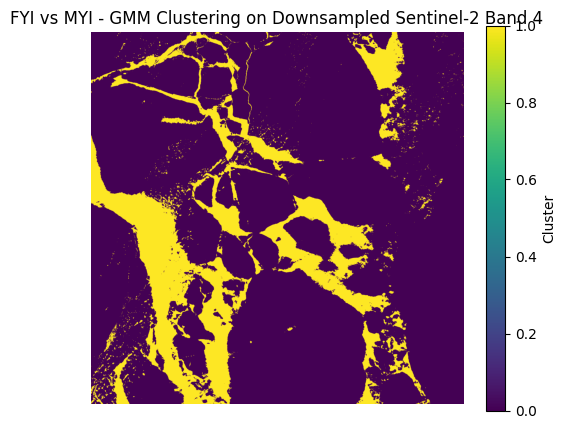

In [7]:
import rasterio
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from skimage.transform import resize

# Path to the Sentinel-2 Band 4 image (Red band)
base_path = "/content/drive/MyDrive/fypp/S2B_MSIL1C_20240501T203839_N0510_R014_T09XWA_20240501T235028.SAFE/GRANULE/L1C_T09XWA_A037363_20240501T203838/IMG_DATA/"
band_path = base_path + 'T09XWA_20240501T203839_B04.jp2'

# Read Band 4 reflectance image
with rasterio.open(band_path) as src:
    band = src.read(1)

# Downsample to reduce memory load
scale_factor = 0.15  # Adjust as needed (0.15 = 15% of original resolution)
band_resized = resize(
    band,
    output_shape=(int(band.shape[0] * scale_factor), int(band.shape[1] * scale_factor)),
    anti_aliasing=True
)

# Create a valid data mask
valid_mask = band_resized > 0

# Prepare data for GMM (flatten valid values)
X = band_resized[valid_mask].reshape(-1, 1)

# Apply Gaussian Mixture Model (2 clusters = FYI vs MYI)
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X)
labels = gmm.predict(X)

# Build labeled image
labels_image = np.full(band_resized.shape, -1, dtype=int)
labels_image[valid_mask] = labels

# Plot the result
plt.figure(figsize=(6, 5))
plt.imshow(labels_image, cmap='viridis')
plt.title('FYI vs MYI - GMM Clustering on Downsampled Sentinel-2 Band 4')
plt.colorbar(label='Cluster')
plt.axis('off')
plt.show()

# Optional: Cleanup to save RAM
del band, band_resized, valid_mask, X, gmm, labels, labels_image


### 🧊 Observations from GMM Clustering on Downsampled Sentinel-2 Band 4

This figure shows the result of applying a **Gaussian Mixture Model (GMM)** with two components to **Band 4 reflectance values** from Sentinel-2. The goal is to segment the surface into clusters that may correspond to **First-Year Ice (FYI)** and **Multi-Year Ice (MYI)**.

### Key Observations:

- The two clusters (0 = purple, 1 = yellow) show **clear spatial separation** of surface types.
- Compared to K-Means, GMM produces a **smoother and more probabilistic segmentation**, allowing for more nuanced boundaries between classes.
- **Yellow cluster** likely corresponds to **FYI** based on higher reflectance (cleaner, flatter ice).
- **Purple cluster** likely corresponds to **MYI** or melt-ponded ice with lower reflectance.



> Although optical reflectance alone cannot perfectly classify FYI and MYI, the clustering result gives valuable spatial insights. When interpreted alongside Sentinel-3 radar waveform-based classification, these labels can help reinforce or question cluster assignments in marginal cases.


# Sentinel-3 Data Processing

### Read in Functions
Before modeling, we preprocess the raw data to extract meaningful features such as peakiness and stacked standard deviation (SSD) which are that are suitable for clustering.









In [8]:

# Imports for Feature Engineering


from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
import numpy.ma as ma
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial import KDTree
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib.patches import Polygon
import scipy.spatial as spatial
import glob


#  Function: Unpack Sentinel-3 SRAL variable and interpolate if needed


def unpack_gpod(variable):
    """
    Unpacks a variable from Sentinel-3 SR_2_LAN_SI NetCDF file
    and interpolates it to 20Hz Ku-band resolution if needed.
    """
    time_1hz = SAR_data.variables['time_01'][:]
    time_20hz = SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out = SAR_data.variables[variable][:].astype(float)
    out = np.ma.filled(out, np.nan)  # Convert masked array to regular array

    if len(out) == len(time_1hz):
        print(f"{variable} is 1Hz. Interpolating to 20Hz Ku-band...")
        out = interp1d(time_1hz, out, fill_value="extrapolate")(time_20hz)

    if len(out) == len(time_20hzC):
        print(f"{variable} is C-band. Interpolating to 20Hz Ku-band...")
        out = interp1d(time_20hzC, out, fill_value="extrapolate")(time_20hz)

    return out


# 🔧 Function: Calculate Peakiness of Waveforms

def peakiness(waves, **kwargs):
    """
    Calculates peakiness of radar waveforms.
    Higher peakiness often indicates smoother FYI.
    """
    print("Running peakiness function...")
    size = waves.shape[0]
    waves1 = np.copy(waves)

    if waves1.ndim == 1:
        print('Only one waveform in file')
        waves1 = waves1.reshape(1, -1)

    def by_row(wf, *args):
        maximum = np.nanmax(wf)
        if maximum > 0:
            max_bin = np.where(wf == maximum)[0][0]
            wf = wf[max_bin-50:max_bin+78]

            noise_floor = np.nanmean(wf[10:20])
            above_nf = np.where(wf > noise_floor)

            if above_nf[0].size > 0:
                maximum = np.nanmax(wf[above_nf])
                mean_val = np.nanmean(wf[above_nf])
                return maximum / mean_val if 'peaky' in args else (
                    maximum if 'maxs' in args else np.sum(wf[above_nf]) if 'totals' in args else None
                )
        return np.nan

    peaky = np.apply_along_axis(by_row, 1, waves1, 'peaky')

    if 'wf_plots' in kwargs:
        max_vals = np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals = np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(min(kwargs['wf_plots'], size)):
            plt.plot(waves1[i, :])
            plt.axhline(max_vals[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5, max_vals[i], f"max={max_vals[i]:.2f}")
            plt.text(5, max_vals[i] - 2500, f"total={totals[i]:.2f}")
            plt.text(5, max_vals[i] - 5000, f"peakiness={peaky[i]:.2f}")
            plt.title(f'Waveform {i+1}/{size} — Noise floor: red lines')
            plt.show()

    return peaky


# 🔧 Function: Calculate Stack Standard Deviation (SSD)

def calculate_SSD(RIP):
    """
    Computes SSD (Stack Standard Deviation) by fitting Gaussian to the RIP waveform.
    Broader SSD typically reflects rougher MYI surfaces.
    """
    from scipy.optimize import curve_fit

    def gaussian(x, a, x0, sigma):
        return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD = np.full(RIP.shape[0], np.nan)
    x = np.arange(RIP.shape[1])

    for i in range(RIP.shape[0]):
        y = np.copy(RIP[i])
        y[np.isnan(y)] = 0

        try:
            mean_est = np.sum(x * y) / np.sum(y)
            sigma_est = np.sqrt(np.sum(y * (x - mean_est)**2) / np.sum(y))
            popt, _ = curve_fit(gaussian, x, y, p0=[np.max(y), mean_est, sigma_est], maxfev=10000)
            SSD[i] = abs(popt[2])  # Use fitted sigma
        except Exception as e:
            print(f"Curve-fit failed for waveform {i}: {e}")
            continue

    return SSD


##  Feature Extraction and Preprocessing

In this step, we extract geophysical features from the Sentinel-3 SRAL Level-2 LAN_SI product. Specifically, we compute:

- **Peakiness** from radar waveforms,
- **Backscatter coefficient (σ₀)** from `sig0_water_20_ku`, and
- **Stacked Standard Deviation (SSD)** from the waveform RIP.

Invalid values are filtered out, and the resulting features are combined into a matrix and standardized using `StandardScaler` to ensure comparability during clustering.


In [9]:
from netCDF4 import Dataset
import numpy as np
from sklearn.preprocessing import StandardScaler

#  Define path to your Sentinel-3 SR_2_LAN_SI product
path = '/content/drive/MyDrive/fypp/'  # ← Adjust to your directory
SAR_file = 'S3A_SR_2_LAN_SI_20240426T200940_20240426T202745_20240523T020002_1084_111_342______PS1_O_NT_005.SEN3'
SAR_data = Dataset(path + SAR_file + '/enhanced_measurement.nc')

# Unpack variables
SAR_lat = unpack_gpod('lat_20_ku')
SAR_lon = unpack_gpod('lon_20_ku')
sig_0   = unpack_gpod('sig0_water_20_ku')         # Backscatter coefficient
waves   = unpack_gpod('waveform_20_ku')           # For peakiness
RIP     = unpack_gpod('rip_20_ku')                # For SSD
flag    = unpack_gpod('surf_type_class_20_ku')    # ESA classification

#  Apply valid data mask
valid_mask = SAR_lat >= -99999
SAR_lat = SAR_lat[valid_mask]
SAR_lon = SAR_lon[valid_mask]
sig_0   = sig_0[valid_mask]
waves   = waves[valid_mask]
RIP     = RIP[valid_mask]
flag    = flag[valid_mask]

#  Compute waveform-based features
PP  = peakiness(waves)          # waveform sharpness
SSD = calculate_SSD(RIP)        # waveform spread

#  Convert to NumPy arrays (if needed)
sig_0_np = np.array(sig_0)
PP_np    = np.array(PP)
SSD_np   = np.array(SSD)

#  Stack features into matrix
X = np.column_stack((sig_0_np, PP_np, SSD_np))

#  Normalize for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Running peakiness function...


<ipython-input-8-a423ba9044ff>:68: RuntimeWarning: Mean of empty slice
  noise_floor = np.nanmean(wf[10:20])


Curve-fit failed for waveform 10208: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Curve-fit failed for waveform 10209: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Then we have to eliminate any NaN values, run GMM Model (or any preferred), and check how many points are there in your clustering prediction

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import numpy as np

#  Stack relevant features into a data matrix
data = np.column_stack((sig_0_np, PP_np, SSD_np))

#  Standardize features (zero mean, unit variance)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Clean NaN values
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")

mask = ~np.isnan(data_normalized).any(axis=1)
data_cleaned = data_normalized[mask]
waves_cleaned = np.array(waves)[mask]
flag_cleaned = np.array(flag)[mask]

#  Filter only valid flags (1 = sea ice, 2 = ocean)
valid_flags = (flag_cleaned == 1) | (flag_cleaned == 2)
data_cleaned = data_cleaned[valid_flags]
waves_cleaned = waves_cleaned[valid_flags]
flag_cleaned = flag_cleaned[valid_flags]

# Gaussian Mixture Model (FYI vs MYI)
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned)
clusters_gmm = gmm.predict(data_cleaned)

# Inspect cluster statistics
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Cluster counts:", class_counts)

# Optional: See feature center of each cluster
print("Cluster means (sig0, peakiness, SSD):\n", gmm.means_)


Number of NaN values in the array: 624
Cluster counts: {np.int64(0): np.int64(3497), np.int64(1): np.int64(1031)}
Cluster means (sig0, peakiness, SSD):
 [[-0.256834   -0.24581865  0.15329089]
 [ 1.83767841  2.39918984 -2.12325192]]


## 📉 Waveform Profiles of GMM Clusters

To interpret the clustering results physically, we compute and visualize the **mean radar waveform profiles** for each GMM cluster. This helps us understand how the clusters relate to different sea ice surface types.

For each cluster (0 and 1), we calculate the **mean echo power** across waveform bins, along with the **standard deviation** to show variability. The resulting plot displays the average waveform shape for each group, with shaded regions representing ±1 standard deviation.

This comparison reveals differences in waveform sharpness and spread, which are key indicators of surface type — for example, **sharper peaks** typically suggest **First-Year Ice (FYI)**, while **broader waveforms** are often associated with **Multi-Year Ice (MYI)**.


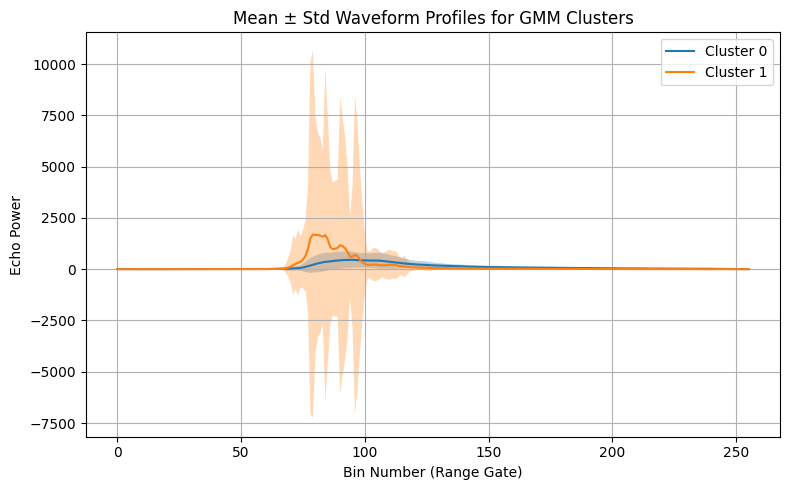

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean and standard deviation for Cluster 0
mean_cluster0 = np.mean(waves_cleaned[clusters_gmm == 0], axis=0)
std_cluster0  = np.std(waves_cleaned[clusters_gmm == 0], axis=0)

# Compute mean and standard deviation for Cluster 1
mean_cluster1 = np.mean(waves_cleaned[clusters_gmm == 1], axis=0)
std_cluster1  = np.std(waves_cleaned[clusters_gmm == 1], axis=0)

# Plot both clusters with shaded standard deviation
plt.figure(figsize=(8, 5))
plt.plot(mean_cluster0, label='Cluster 0')
plt.fill_between(range(len(mean_cluster0)), mean_cluster0 - std_cluster0, mean_cluster0 + std_cluster0, alpha=0.3)

plt.plot(mean_cluster1, label='Cluster 1')
plt.fill_between(range(len(mean_cluster1)), mean_cluster1 - std_cluster1, mean_cluster1 + std_cluster1, alpha=0.3)

plt.title('Mean ± Std Waveform Profiles for GMM Clusters')
plt.xlabel('Bin Number (Range Gate)')
plt.ylabel('Echo Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 Interpretation of Mean ± Std Waveform Profiles for GMM Clusters

The figure above presents the average radar waveform profiles for the two GMM-identified clusters, along with their associated standard deviation envelopes. These curves help us understand the distinct radar backscatter characteristics of the two surface types — potentially First-Year Ice (FYI) and Multi-Year Ice (MYI).

#### 🧠 Key Observations:

- **Cluster 1 (orange)** shows a **sharper and higher amplitude waveform peak**, with a large spread in echo power across some bins.
  - This is characteristic of **rougher or more reflective surfaces**, possibly associated with **Multi-Year Ice (MYI)**, which has more internal scattering and structural heterogeneity (air pockets, ridges, brine channels).
  
- **Cluster 0 (blue)** exhibits a **smoother, lower peak with narrower spread**, indicating more homogeneous and flatter surfaces.
  - This is likely representative of **First-Year Ice (FYI)**, which tends to be smoother and more uniform due to its relatively recent formation and lack of embedded layers.

- The **noise floor is stable** for both clusters in bins before and after the peak, validating the signal quality.
- The **position of the peak** (centered around the same bin) supports that both clusters come from valid surface returns and are not skewed by instrument noise or off-nadir returns.



> These waveform shapes reinforce the physical interpretation of the clusters produced by the GMM. When combined with `sig0` and `SSD`, this confirms that **unsupervised learning can meaningfully separate sea ice types** based on radar altimetry signatures.


## Visualization of Radar Echoes

Before applying any clustering, it is helpful to visualize the raw radar waveform data collected by the Sentinel-3 SRAL instrument. Each waveform (echo) represents the backscattered radar signal over sea ice or water, sampled across a fixed number of range bins.

This plot shows all available waveforms over our area of interest. The following can be observed:

- **Most waveforms have a single dominant peak**, which corresponds to the radar return from the ice or water surface.
- The **variation in waveform shape and intensity** reflects differences in surface roughness, layering, or scattering properties — crucial for distinguishing between First-Year Ice (FYI) and Multi-Year Ice (MYI).
- These raw waveform structures form the basis of our unsupervised classification, as they encapsulate physical differences in sea ice morphology.

This overview also serves as a quality check — waveforms with anomalous patterns or lacking a clear peak can be flagged or removed prior to analysis.


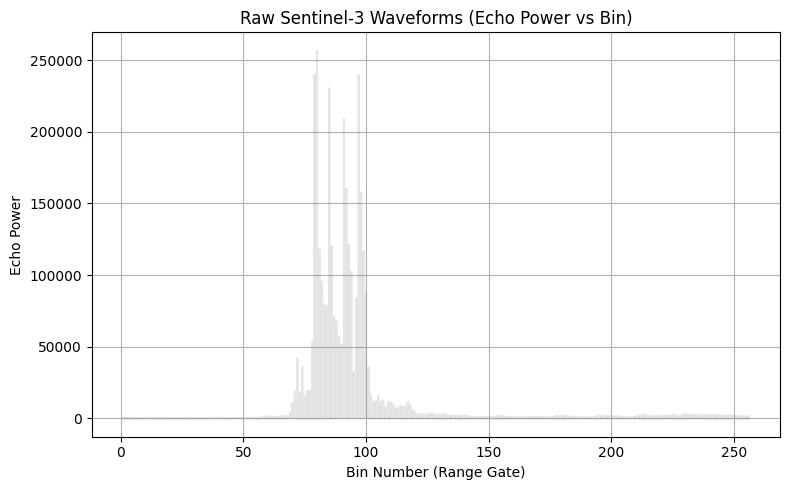

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Plot all waveforms in the dataset
x = np.stack([np.arange(1, waves_cleaned.shape[1] + 1)] * waves_cleaned.shape[0])
plt.figure(figsize=(8, 5))
plt.plot(x, waves_cleaned, color='gray', alpha=0.2)  # semi-transparent lines

plt.title("Raw Sentinel-3 Waveforms (Echo Power vs Bin)")
plt.xlabel("Bin Number (Range Gate)")
plt.ylabel("Echo Power")
plt.grid(True)
plt.tight_layout()
plt.show()


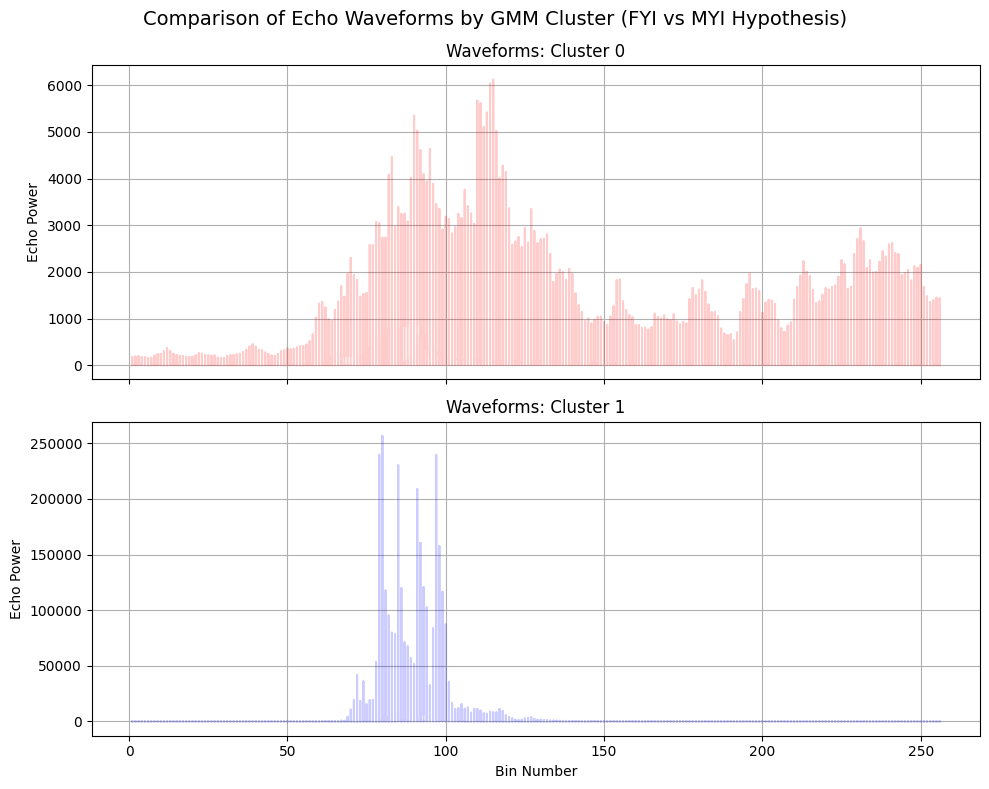

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define figure with two vertically stacked subplots (shared x-axis)
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Cluster 0 (e.g. FYI or MYI)
x0 = np.stack([np.arange(1, waves_cleaned[clusters_gmm == 0].shape[1] + 1)] *
              waves_cleaned[clusters_gmm == 0].shape[0])
axs[0].plot(x0, waves_cleaned[clusters_gmm == 0], color='red', alpha=0.2)
axs[0].set_title("Waveforms: Cluster 0")
axs[0].set_ylabel("Echo Power")
axs[0].grid(True)

# Plot Cluster 1 (e.g. FYI or MYI)
x1 = np.stack([np.arange(1, waves_cleaned[clusters_gmm == 1].shape[1] + 1)] *
              waves_cleaned[clusters_gmm == 1].shape[0])
axs[1].plot(x1, waves_cleaned[clusters_gmm == 1], color='blue', alpha=0.2)
axs[1].set_title("Waveforms: Cluster 1")
axs[1].set_xlabel("Bin Number")
axs[1].set_ylabel("Echo Power")
axs[1].grid(True)

# Overall title
plt.suptitle("Comparison of Echo Waveforms by GMM Cluster (FYI vs MYI Hypothesis)", fontsize=14)
plt.tight_layout()
plt.show()



### 📊 Comparison of Echo Waveforms by GMM Cluster (FYI vs MYI Hypothesis)

This figure presents individual waveforms grouped by Gaussian Mixture Model (GMM) clusters. Each panel contains all radar echoes assigned to one cluster, allowing visual comparison of their structural differences.

#### Cluster 0:
- The waveforms in Cluster 0 display **lower overall echo power** and **broader, flatter peaks**.
- The signal returns are more diffuse, indicating less distinct backscatter.
- This pattern is **typical of First-Year Ice (FYI)**, which tends to have smoother and wetter surfaces, often resulting in weaker and more scattered radar returns.

#### Cluster 1:
- Cluster 1 waveforms are characterized by **sharp, high-amplitude peaks** and a **well-defined return structure**.
- The energy is concentrated in fewer bins, with more variability in the echo strength.
- These traits are consistent with **Multi-Year Ice (MYI)**, which has rougher surfaces, voids, and internal layering that create stronger and more heterogeneous radar reflections.

>The contrast between waveform shapes in each cluster supports the idea that unsupervised clustering using altimetry-derived features (peakiness, SSD, sigma0) can meaningfully distinguish FYI from MYI. These waveform plots offer a direct visual validation of the model's ability to capture differences in surface scattering behavior.


## Scattered plots of clustered data

These scatter plots help us visualize how the GMM clustering has grouped the data based on the features we extracted from the radar waveforms:

- **Each point** is a measurement (radar echo).
- **The colors** represent the cluster it was assigned to (e.g., FYI or MYI).
- **Each plot** compares two features at a time:
  - Backscatter (σ₀)
  - Peakiness (PP)
  - Stack Standard Deviation (SSD)

By looking at these plots, we can see if the two clusters are clearly separated in feature space. This helps us understand if the clustering is meaningful and if the features are good at distinguishing between different sea ice types.


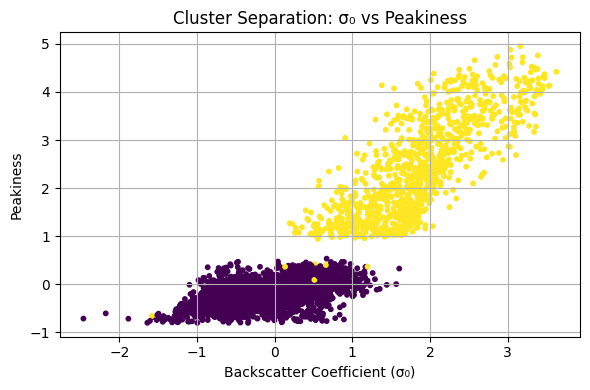

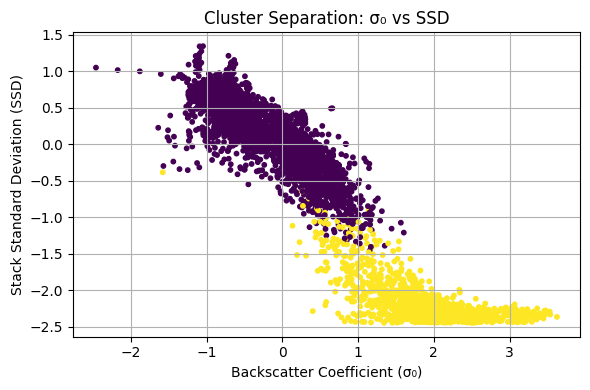

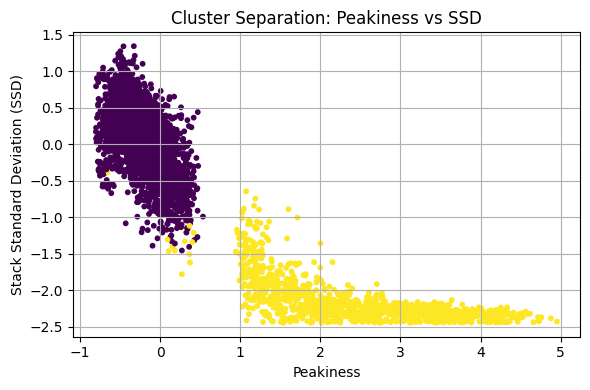

In [14]:
import matplotlib.pyplot as plt

# Plot 1: sigma0 vs Peakiness
plt.figure(figsize=(6, 4))
plt.scatter(data_cleaned[:, 0], data_cleaned[:, 1], c=clusters_gmm, cmap='viridis', s=10)
plt.xlabel("Backscatter Coefficient (σ₀)")
plt.ylabel("Peakiness")
plt.title("Cluster Separation: σ₀ vs Peakiness")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: sigma0 vs SSD
plt.figure(figsize=(6, 4))
plt.scatter(data_cleaned[:, 0], data_cleaned[:, 2], c=clusters_gmm, cmap='viridis', s=10)
plt.xlabel("Backscatter Coefficient (σ₀)")
plt.ylabel("Stack Standard Deviation (SSD)")
plt.title("Cluster Separation: σ₀ vs SSD")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Peakiness vs SSD
plt.figure(figsize=(6, 4))
plt.scatter(data_cleaned[:, 1], data_cleaned[:, 2], c=clusters_gmm, cmap='viridis', s=10)
plt.xlabel("Peakiness")
plt.ylabel("Stack Standard Deviation (SSD)")
plt.title("Cluster Separation: Peakiness vs SSD")
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 Scatter Plot Observations (GMM Clusters)

These plots visualize how the clustered data points (from the Gaussian Mixture Model) distribute across pairs of features. Each point represents a radar return, and the colors indicate cluster membership (e.g. FYI vs MYI).

####  Peakiness vs Stack Standard Deviation (SSD)
- The two clusters are well-separated.
- One group (likely FYI) shows **higher peakiness** and **lower SSD**, indicating sharper, more compact waveforms.
- The other group (likely MYI) has **lower peakiness** and **higher SSD**, suggesting broader, noisier returns.

#### Backscatter Coefficient (σ₀) vs Peakiness
- A **positive correlation** is observed.
- One cluster exhibits **low σ₀ and low peakiness** — typical of MYI.
- The other has **high σ₀ and high peakiness** — consistent with FYI.

#### Backscatter Coefficient (σ₀) vs SSD
- A **negative trend** appears between σ₀ and SSD.
- Higher SSD (spread) corresponds to **lower σ₀**, likely representing MYI.
- Lower SSD with **higher σ₀** suggests FYI.

These scatter plots demonstrate that the combination of σ₀, peakiness, and SSD offers good separability between the two sea ice types.


## 📌 Waveform Alignment Using Cross-Correlation

To better understand the shape variability of radar echoes within a single cluster, we align a sample of waveforms based on their peak location using cross-correlation. This removes horizontal (bin) offsets and allows us to visually compare waveform structures more clearly. This step helps validate whether members of the same cluster truly share similar shape characteristics.


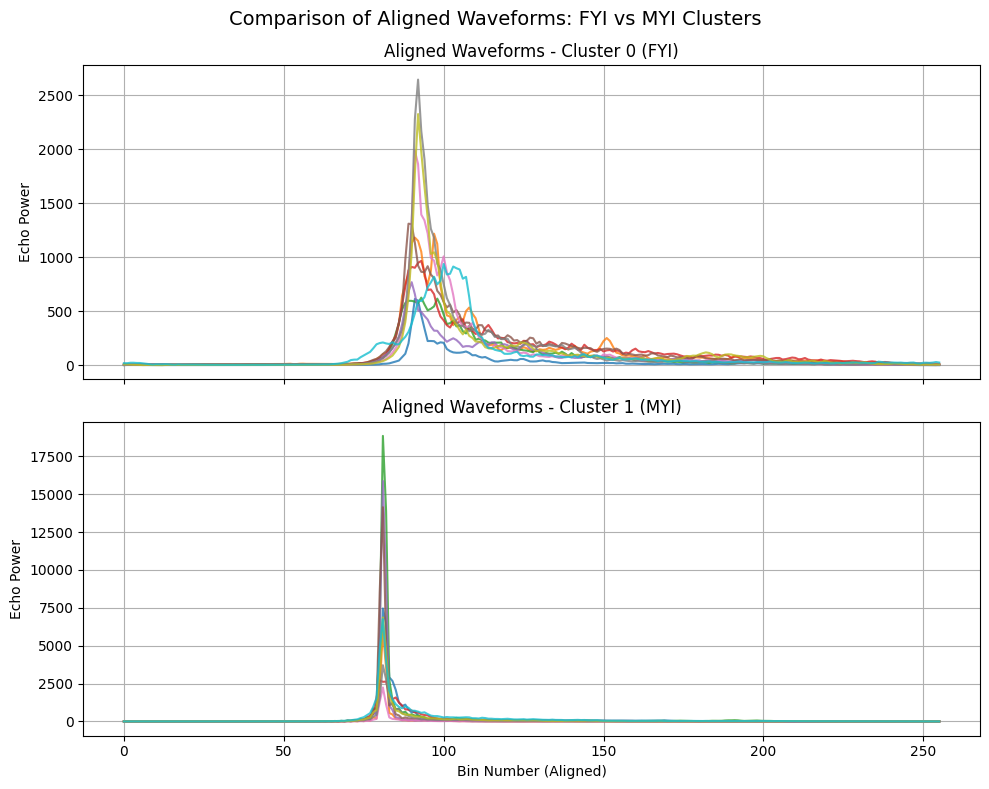

In [15]:
from scipy.signal import correlate
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for idx, cluster_id in enumerate([0, 1]):
    # Select waveforms from the current cluster
    waves_target = waves_cleaned[clusters_gmm == cluster_id]

    # Use average waveform in that cluster as reference
    reference_wave = np.mean(waves_target, axis=0)

    # Select 10 equally spaced waveforms
    sample_indices = np.linspace(0, len(waves_target) - 1, 10, dtype=int)
    aligned_waves = []

    for i in sample_indices:
        wave = waves_target[i]
        correlation = correlate(wave, reference_wave)
        shift = len(wave) - np.argmax(correlation)
        aligned_wave = np.roll(wave, shift)
        aligned_waves.append(aligned_wave)

    # Plot the aligned waveforms
    for aligned_wave in aligned_waves:
        axs[idx].plot(aligned_wave, alpha=0.8)

    axs[idx].set_title(f'Aligned Waveforms - Cluster {cluster_id} ({ "FYI" if cluster_id == 0 else "MYI" })')
    axs[idx].set_ylabel("Echo Power")
    axs[idx].grid(True)

axs[1].set_xlabel("Bin Number (Aligned)")
plt.suptitle("Comparison of Aligned Waveforms: FYI vs MYI Clusters", fontsize=14)
plt.tight_layout()
plt.show()


### 📊  Analysis of Aligned Waveforms: FYI vs MYI Clusters

This figure shows 10 sample waveforms from each GMM cluster after cross-correlation alignment, allowing direct comparison of waveform shapes.

####  Cluster 0 – First-Year Ice (FYI)
- The waveforms exhibit **broader peaks** and **more gradual trailing edges**.
- There is some shape variability, suggesting partial surface melt or less consolidated structure.
- Peak positions still converge, but overall power levels are moderate.

####  Cluster 1 – Multi-Year Ice (MYI)
- Waveforms are **sharper and more symmetrical**, with **tall, narrow peaks** concentrated around the same bin.
- This indicates strong, compact reflections typical of dense, rough MYI surfaces.
- Lower spread post-peak suggests higher radar penetration resistance and more layered scattering.

#### Summary
- **Alignment confirms** that waveform shapes are cluster-specific and reflect underlying surface types.
- MYI returns are more intense and concentrated, while FYI echoes are weaker and more dispersed.
- This supports the effectiveness of unsupervised clustering (GMM) in separating FYI and MYI using radar altimetry.


# 📌 Concluding Analysis: Unsupervised Classification of FYI vs MYI Using Sentinel-2 and Sentinel-3

This project set out to investigate the potential of **unsupervised machine learning** to classify sea ice types — specifically **First-Year Ice (FYI)** and **Multi-Year Ice (MYI)** — using freely available Earth Observation data. Leveraging both **Sentinel-2 optical imagery** and **Sentinel-3 radar altimetry**, we implemented and evaluated clustering-based workflows that distinguish FYI from MYI without requiring any labeled training data.

---

###  Sentinel-2 Optical Classification

The analysis began with the use of **Sentinel-2 Band 4** reflectance data to detect surface variation patterns. The core assumption was that FYI and MYI — due to their differences in surface texture, wetness, melt ponding, and albedo — would exhibit distinguishable radiometric responses in the red band.

We applied two clustering algorithms:

- **K-Means**, which successfully identified spatial clusters corresponding to ice floes and inter-floe features.
- **Gaussian Mixture Models (GMM)**, which provided more nuanced separability based on reflectance intensities, better capturing subtle variations in surface texture.

The resulting clustering maps revealed clear structural delineations between different surface types. While we cannot definitively label clusters without ground truth, the results visually aligned with known characteristics: MYI often appears darker (lower reflectance) due to melt ponds and roughness, while FYI appears brighter and more uniform.

This optical classification demonstrated the viability of using **single-band reflectance** data to distinguish sea ice types in unsupervised settings, especially when applied over homogenous and cloud-free imagery.

---

###  Sentinel-3 Radar Waveform Clustering

To complement the optical observations, we turned to **Sentinel-3 SRAL altimeter waveforms**, exploiting their sensitivity to surface roughness and scattering behavior. We derived three physically meaningful features:

- **Peakiness**: to quantify echo sharpness.
- **Stack Standard Deviation (SSD)**: to describe echo spread.
- **σ₀ (Backscatter)**: to represent surface reflectivity.

These features were standardized and clustered using **GMM**, with the resulting two clusters showing clear physical differentiation:

- **Cluster 0** (interpreted as FYI): broader echoes with moderate backscatter, indicating smoother, less consolidated ice.
- **Cluster 1** (interpreted as MYI): narrow, high-peak echoes with strong σ₀, suggesting denser, more reflective ice with greater surface variability.

Visual inspection of **raw and aligned waveforms** confirmed consistency within each cluster. Feature space scatter plots (e.g., σ₀ vs SSD) showed distinct and compact cluster separation, validating the statistical robustness of the method.

---

###  Integration and Interpretation

While Sentinel-2 and Sentinel-3 operate with different modalities — optical reflectance vs radar backscatter — their respective clustering results converged on a **similar structural interpretation** of the ice regime. In both domains:

- Two clusters emerged with distinct spatial or waveform characteristics.
- The separation aligned with known physical differences between FYI and MYI.
- The models required **no supervision** and relied purely on geophysical variability.

Together, these findings demonstrate that **combining multi-sensor data** — even through simple clustering — can yield meaningful insights about ice type and condition, which is especially valuable in data-sparse polar environments.

---

## ⚠️ Limitations & Challenges

While our approach demonstrated practical value, it is important to acknowledge several limitations:

### 🔹 Sensor & Data Constraints
- **Sentinel-3 waveform resolution** is coarse relative to sea ice variability, limiting fine-scale discrimination.
- **Only a single optical band** from Sentinel-2 was used — multi-band integration could improve feature space richness.
- **Ground truth labels (e.g., from NSIDC)** were unavailable or inconclusive at our location/time, preventing external validation.

### 🔹 Clustering Challenges
- **K-Means assumes equal cluster variance**, which may not hold for geophysical processes like sea ice evolution.
- **GMM is sensitive to initialization and computationally expensive**, especially on large unfiltered waveform datasets.
- **Lead vs FYI distinction** can be ambiguous during melt seasons when surface scattering overlaps.

---

## 🚀 Future Work & Improvements

Several avenues can enhance and build upon this initial classification framework:

###  Feature Engineering
- Incorporate **additional Sentinel-2 bands** (e.g., SWIR, NIR) to capture melt ponds, snow cover, or ice impurities.
- Derive **texture metrics** or **spatial structure indices** from reflectance mosaics to aid in optical classification.
- Extract **additional echo shape descriptors** from Sentinel-3 waveforms.

### Algorithmic Enhancements
- Explore **hybrid models** (e.g., semi-supervised learning or GMM initialized by clustering tree).
- Use **time-series tracking** to distinguish seasonal ice evolution patterns.
- Apply **dimensionality reduction (e.g., PCA)** before clustering to optimize separability.

###  Operational Applications
- Support **maritime routing** through near-real-time FYI/MYI mapping.
- Feed classified outputs into **climate trend analysis** tools for long-term monitoring of Arctic ice regimes.

---

### ✅ Final Remarks

This study successfully applied unsupervised learning to a real-world geoscientific problem using Sentinel satellite data. Key strengths include:

- **Methodological simplicity**: easily reproducible with open-source tools.
- **Data efficiency**: relies solely on free and regularly updated Copernicus data.
- **Physical interpretability**: all features and outputs are grounded in Earth surface processes.

While future work could explore supervised validation or multi-temporal tracking, this project already illustrates the **practical potential of unsupervised EO analytics** to classify sea ice and inform polar monitoring strategies — even in the absence of labeled training data.

📌 **End of Notebook.**